In [1]:
!pip install transformers

In [2]:
!nvidia-smi

Mon Apr  4 18:15:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:3D:00.0 Off |                  Off |
| 33%   31C    P8    35W / 260W |      3MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:3F:00.0 Off |                  Off |
| 33%   

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

%matplotlib inline

#change sheetname
# train_df=pd.read_excel('../../data/cotraining1.xlsx', sheet_name=0)
# test_df=pd.read_excel('../../data/data.xlsx', sheet_name=2)
val_df=pd.read_excel('../../data/data.xlsx', sheet_name=1)
test_df=pd.read_excel('../../data/connor.xlsx', sheet_name=0)
# noisy_train_df=pd.read_excel('../../data/noisy_train_cot_0.xlsx', sheet_name=0)
bad_chars = [';', ':', "(", ")", "-", "'", "\"", "_", ".", ",", " "]

def components(df):
    statements = list(df['statements'])
    labels = list(df['labels'])
    genes = list(df['target_genes'])
    return statements, labels, genes


In [5]:
train_df

,Unnamed: 0,target_genes,statements,labels,Unnamed: 0.1
0,0,OXA-51,"Both are ambler class D ss-lactamases, which o...",1,NaN
1,1,ttyh,Tweety-homolog (Ttyh) Family Encodes the Pore-...,0,NaN
2,2,MXI1,"Regardless of the oxygen, in senescent cells P...",0,NaN
3,3,cst,OBJECTIVES: Stress and burn-out among surgical...,0,NaN
4,4,opu,Social support (via Facebook) may have a posit...,0,NaN
...,...,...,...,...,...
17797,17797,pqe,Target pre-cueing conditions did not affect th...,0,NaN
17798,17798,MexA,"Two P . aeruginosa efflux pumps, MexAB-OprM an...",1,7109.0
17799,17799,mfd,"6c) . The most abundant ARG, mfd, conferring r...",1,9253.0
17800,17800,hch,"Fokin, and Irina M . Roshchevskaya . Body surf...",0,NaN


In [42]:
# noisy_train_df

,Unnamed: 0,target_genes,statements,labels
0,0,AAC(2')-Ia,The enzymes generally promote the acetylation ...,1
1,1,AAC(2')-Ia,Many bacterial pathogens acetylate their pepti...,1
2,2,AAC(2')-Ia,"In Providencia stuartii, a Gram-negative speci...",1
3,3,AAC(2')-Ia,"smegmatis, and characterization of AG resistan...",1
4,4,AAC(2')-Ia,"In leaderless mRNAs, there is no Shine-Dalgarn...",1
...,...,...,...,...
18470,18470,YojI,We demonstrate that YojI is capable of pumping...,1
18471,18471,YojI,The outer membrane protein TolC in addition to...,1
18472,18472,YojI,"Thus, one obvious explanation for the protecti...",1
18473,18473,YojI,"In the present study, we showed that yojI, an ...",1


In [4]:
test_df

,Unnamed: 0,target_genes,pmcid,statements,review_label,label,Remarks,labels,connor_notes
0,1436,msbA,4979069,coli conclude that the conformational transiti...,-1.0,1,ABC transporter,0,NaN
1,343,CpxR,5063474,"The results showed that, apart from the previo...",-1.0,-1,NaN,0,NaN
2,1382,mphI,5760710,MphI shares high sequence identity (94%) to ho...,1.0,1,NaN,0,Note that the actual conclusion of the linked ...
3,187,cpxA,3319533,The disruption at cpxAR operon was confirmed w...,-1.0,1,plasmid,0,NaN
4,1854,sdiA,2812512,It was recently discovered that S . Typhimuriu...,-1.0,-1,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...
95,874,kamB,2760815,"tenebrarius, for which a modification to the o...",NaN,1,NaN,0,NaN
96,1481,msbA,4979069,Fluorescence was followed in a LS 55B Luminesc...,NaN,1,NaN,0,NaN
97,613,FosB,3985756,FosBSa crystallized with Zn2+ in the active si...,NaN,-1,NaN,0,not enough information in this snippet to know
98,102,ANT(2'')-Ia,4313920,3A) . Comparative structural analysis searches...,NaN,1,NaN,1,NaN


In [7]:
val_df

,target_genes,statements,labels
0,NDM-1,5% in Indian and Pakistan hospitals . In addit...,1
1,otrC,"Additionally, the significantly enhanced vanco...",1
2,FosB,"Thus, the P1 space group appears to be the res...",1
3,CpxR,"In Klebsiella pneumoniae, CpxR is involved in ...",1
4,mfd,"3) . Thus, the reduced spontaneous mutation ra...",1
...,...,...,...
281,rphB,225-25 muM rifampin and 68 . 5 nM RphB . Enzym...,0
282,emrE,"Thus, EmrE can exist in solution in a stable n...",0
283,sdiA,"Additionally, a second microarray study was pe...",0
284,CTX-M-94,"3 and 7 . 5, for both CTX-M-94 and -100 enzyme...",0


In [5]:
# train_statements, train_labels, genes=components(train_df)
test_statements, test_labels, test_genes=components(test_df)
val_statements, val_labels, val_genes=components(val_df)

In [6]:
# noisy_train_statements, noisy_train_labels, noisy_train_genes=components(noisy_train_df)

In [7]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
Device name: Quadro RTX 8000


In [8]:
torch.cuda.set_device(1)

In [9]:
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(42)    # Set seed for reproducibility

In [10]:
from transformers import AutoTokenizer

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [11]:
from transformers import AdamW
from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [12]:
# import seaborn as sns

# # Encode our concatenated data
# encoded_seq = [tokenizer.encode(seq, add_special_tokens=True) for seq in statements]

# token_len=[]
# # Find the maximum length
# token_len=[len(sent) for sent in encoded_seq]
# # print('Max length: ', max_len)
# sns.distplot(token_len)
# plt.xlim([0, 1024]);
# plt.xlabel('Token count')

In [13]:
#position_embeddings

def pids(statements, genes):
    positional_embeddings=[]
    for idx in range(len(statements)):
        tokens=statements[idx].split()
        pid_list=[0]
        for token in tokens:
            sub_tokens=tokenizer.tokenize(token) #{'prepare_for_tokenization':True})
            word=tokenizer.convert_tokens_to_string(sub_tokens)
            filtered_gene=''.join(i for i in genes[idx] if not i in bad_chars)
            filtered_word=''.join(i for i in word if not i in bad_chars)
            if filtered_gene.lower() in filtered_word.lower():
                temp_list=[1]*len(sub_tokens) 
            else:
                temp_list=[0]*len(sub_tokens)
            pid_list = [y for x in [pid_list, temp_list] for y in x]
        if(len(pid_list)>512):
            del pid_list[512:]
        elif (len(pid_list)==512 and pid_list[511]==1):
            pid_list[511]=0
        else:
            temp_list=[0]*(512-len(pid_list))
            pid_list = [y for x in [pid_list, temp_list] for y in x]
        # print(pid_list)
        positional_embeddings.append(pid_list)
        # pretokenized_string=tokenizer.convert_tokens_to_string(res_list)
        # print(pretokenized_string)
#     large_df['positional_embeddings']=positional_embeddings
    return positional_embeddings    


# positional_embeddings=small_df['positional_embeddings']

In [14]:
#prepare mask keywords

bad_chars = [';', ':', "(", ")", "-", "'", "\"", "_", ".", ",", " "]

rule1=['resistan', 'efflux']

rule2=["beta-lactamase", "beta lactamase",  "streptogramin inactivation enzyme", 
"fosfomycin inactivation enzyme",
"tetracycline inactivation enzyme ", #AMR gene
"macrolide inactivation enzyme",
"rifampin inactivation enzyme",
"aminoglycoside acetyltransferase", #"AAC",
"chloramphenicol phosphotransferase",
"aminoglycoside phosphotransferase", #"APH",
"chloramphenicol acetyltransferase", #"CAT", 
"aminoglycoside nucleotidyltransferase", #"ANT",
"lincosamide nucleotidyltransferase", #"LNU" 
"streptothricin acetyltransferase", #"SAT", 
"fusidic acid inactivation enzyme",
"Edeine acetyltransferase", 
"viomycin phosphotransferase", 
"ciprofloxacin phosphotransferase",
"Bah amidohydrolase",
"MDR",
"MRSA"]

rule3=['bla', 'mec']

rule4=['MIC', 'increase', 'fold']

antibiotics_df=pd.read_excel('../../data/antibiotics.xlsx', sheet_name=0)
temp_keywords=list(antibiotics_df['antibiotics'])
temp_keywords = [y for x in [temp_keywords, rule1] for y in x]
temp_keywords = [y for x in [temp_keywords, rule2] for y in x]
temp_keywords = [y for x in [temp_keywords, rule3] for y in x]
temp_keywords = [y for x in [temp_keywords, rule4] for y in x]
mask_keywords=[]
for i in range(len(temp_keywords)):
    keywords=temp_keywords[i].replace("-", " ").split()
#     for j in range(len(keywords)):
#         filtered_word=''.join(k for k in keywords[j] if not k in bad_chars)
    mask_keywords = [y for x in [mask_keywords, keywords] for y in x]
mask_keywords=[i for i in mask_keywords if len(i)>2]

In [15]:
mask_keywords=random.sample(mask_keywords, int(len(mask_keywords)*0.25))

In [16]:
def preprocessing_for_bert(statements, labels, genes):
    ##########################################################  

    #sub_tokens doesn't have [SEP] at the end
    #Exclude CLS SEP and prompt
    all_masks=[]
    for idx in range(len(statements)):
        tokens=statements[idx].split()
        masks=[0]
        for token in tokens:
            sub_tokens=tokenizer.tokenize(token) #{'prepare_for_tokenization':True})
            word=tokenizer.convert_tokens_to_string(sub_tokens)
            #bla+target_gene
            filtered_gene=''.join(i for i in genes[idx] if not i in bad_chars)
            filtered_word=''.join(i for i in word if not i in bad_chars)
            if filtered_gene.lower() in filtered_word.lower():
                temp_list=[0]*len(sub_tokens)
            else:
                flag=0
                for keyword in mask_keywords:
                    filtered_keyword=''.join(i for i in keyword if not i in bad_chars)
                    if filtered_keyword.lower() in filtered_word.lower():
                        flag=1
                        temp_list=[1]*len(sub_tokens)
                        break
                if flag==0:
                    temp_list=[0]*len(sub_tokens)
            masks = [y for x in [masks, temp_list] for y in x]
        if(len(masks)>=512):
            del masks[512:]
            masks[511]=0
#         elif (len(masks)==512 and masks[511]==1):
#             masks[511]=0
#         else:
#             temp_list=[0]*(512-len(masks))
#             masks = [y for x in [masks, temp_list] for y in x]
#         # print(masks)
        all_masks.append(masks)
        
    return all_masks

In [17]:
# train_rule_masks=preprocessing_for_bert(train_statements, train_labels, genes)
val_rule_masks=preprocessing_for_bert(val_statements, val_labels, val_genes)
test_rule_masks=preprocessing_for_bert(test_statements, test_labels, test_genes)

In [18]:
# noisy_train_rule_masks=preprocessing_for_bert(noisy_train_statements, noisy_train_labels, noisy_train_genes)

In [19]:
# train_positional_embeddings=pids(train_statements, genes)
val_positional_embeddings=pids(val_statements, val_genes)
test_positional_embeddings=pids(test_statements, test_genes)

In [20]:
# noisy_train_positional_embeddings=pids(noisy_train_statements, noisy_train_genes)

In [21]:
# X_train = train_statements
X_val = val_statements
# y_train = train_labels
y_val = val_labels

# X_train_pids = train_positional_embeddings
X_val_pids = val_positional_embeddings

In [54]:
# X_noisy_train = noisy_train_statements
# y_noisy_train = noisy_train_labels
# X_noisy_train_pids = noisy_train_positional_embeddings

In [22]:
def tokenize(text, labels, pids):
    inputs = tokenizer(
        text,
        max_length=512,
        truncation=True,
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='pt'
    )
    inputs['labels']=torch.tensor(labels)
    inputs['pids']=torch.tensor(pids)
    return inputs

In [23]:
def tokenize_MLM(text, labels, pids, rule_masks):
    inputs = tokenizer(
        text,
        max_length=512,
        truncation=True,
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='pt'
    )
    inputs['labels']=torch.tensor(labels)
    inputs['pids']=torch.tensor(pids)
    inputs['labels_MLM']=torch.ones(len(inputs['input_ids']),512, dtype=int) 
    #################
    ## MLM ##
    for idx in range(len(inputs['input_ids'])):
        rule_mask=rule_masks[idx]
        for i in range(len(rule_mask)):
            if rule_mask[i]==1:
                inputs['labels_MLM'][idx][i]=inputs['input_ids'][idx][i]
                inputs['input_ids'][idx][i]=tokenizer.mask_token_id
    #################
    return inputs

In [24]:
class BookDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        pids = self.encodings['pids'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'position_ids': pids
        }

In [25]:
class BookDataset_MLM(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        pids = self.encodings['pids'][index]
        labels_MLM=self.encodings['labels_MLM'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'position_ids': pids,
            'labels_MLM': labels_MLM
        }

In [26]:
# train_inputs=tokenize(X_train, y_train, X_train_pids)
val_inputs=tokenize(X_val, y_val, X_val_pids)
test_inputs=tokenize(test_statements, test_labels, test_positional_embeddings)

# train_dataset = BookDataset(train_inputs)
val_dataset = BookDataset(val_inputs)
test_dataset = BookDataset(test_inputs)

In [27]:
# noisy_train_inputs = tokenize(X_noisy_train, y_noisy_train, X_noisy_train_pids)
# noisy_train_dataset = BookDataset(noisy_train_inputs)

In [27]:
train_inputs_MLM=tokenize_MLM(X_train, y_train, X_train_pids, train_rule_masks)
train_dataset_MLM = BookDataset_MLM(train_inputs_MLM)

NameError: name 'X_train' is not defined

In [26]:
# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=16,
#     shuffle=True
# )

# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset,
#     batch_size=16,
# )

# test_dataloader = torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size=16,
# )

In [28]:
import torch.nn.functional as F

In [28]:
def train(model, train_dataloader):
    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=2e-05)

    model.train()

    # Tracking variables
    train_accuracy = []
    train_loss = []
    tp=0
    tn=0
    fp=0
    fn=0
#     for epoch in range(epochs):
    #     loop = tqdm(train_dataloader)
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pids = batch['position_ids'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask,position_ids=pids, labels=labels)
    #     batch = {k: v.to(device) for k, v in batch.items()}
    #     outputs = model(**batch)
        loss = outputs.loss   
        train_loss.append(loss.item())
        b_probabilities = F.softmax(outputs.logits, dim=-1)
        # Get the predictions
        preds = torch.argmax(b_probabilities, dim=1)
    #     print("preds: ", preds[0])
    #     print("labels: ", labels[0])
        # Calculate the accuracy rate
        for i in range(len(labels)):
            if preds[i].item() == 1 and labels[i].item() == 1: 
                tp+=1
            elif preds[i].item() == 1 and labels[i].item() == 0:
                fp+=1
            elif preds[i].item() == 0 and labels[i].item() == 0:
                tn+=1
            elif preds[i].item() == 0 and labels[i].item() == 1:
                fn+=1
        accuracy = (preds == labels).cpu().numpy().mean() * 100
        train_accuracy.append(accuracy)

        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_loss)
    train_accuracy = np.mean(train_accuracy)
    
    beta=0.5
    train_precision_pos=tp/(tp+fp)
    train_recall_pos=tp/(tp+fn)
    train_f1_pos=2*train_precision_pos*train_recall_pos/(train_precision_pos+train_recall_pos)
#     train_balanced_accuracy = (train_recall+(tn/(tn+fp)))/2
    train_precision_neg=tn/(tn+fn)
    train_recall_neg=tn/(tn+fp)
    train_f1_neg=2*train_precision_neg*train_recall_neg/(train_precision_neg+train_recall_neg)
    train_f1_beta_pos=((1+beta*beta)*train_precision_pos*train_recall_pos)/((1+beta*beta)*train_precision_pos*train_recall_pos+beta*beta*train_precision_pos+train_recall_pos)
    
#     train_precision_neg=tn/(tn+fn)
#     train_recall_neg=tn/(tn+fp)
#     train_f1_neg=2*train_precision_pos*train_recall_pos/(train_precision_pos+train_recall_pos)
    train_f1_beta_neg=((1+beta*beta)*train_precision_neg*train_recall_neg)/((1+beta*beta)*train_precision_neg*train_recall_neg+beta*beta*train_precision_neg+train_recall_neg)
    
    train_f1_beta=(train_f1_beta_pos+train_f1_beta_neg)/2
    print(f" check_train_accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    return [train_loss, train_accuracy, train_precision_pos, train_recall_pos, train_f1_pos, train_f1_beta_pos,train_precision_neg, train_recall_neg, train_f1_neg, train_f1_beta_neg, train_f1_beta]  
    
    #         loop.set_description("Epoch: {}".format(epoch))
    #         loop.set_postfix(loss=loss.item())

In [29]:
def train_MLM(model, train_dataloader):

    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=2e-05)
    model.train()

    # Tracking variables
    train_loss = []
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels_MLM'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss   
        train_loss.append(loss.item())
        b_probabilities = F.softmax(outputs.logits, dim=-1)
        # Get the predictions
        preds = torch.argmax(b_probabilities, dim=2)
        loss.backward()
        optimizer.step()
        
    train_loss = np.mean(train_loss)
    return train_loss

In [30]:
# print(train_loss)
# print(train_accuracy)

In [29]:
# Specify loss function
# loss_fn = torch.nn.CrossEntropyLoss()
# model.to(device)
# prob_tp=[]
# prob_fp=[]
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    pred_label=[]
    val_accuracy = []
    val_loss = []
    tp=0
    tn=0
    fp=0
    fn=0
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids = batch['input_ids'].to(device)
        b_labels = batch['labels'].to(device)
        b_attn_mask = batch['attention_mask'].to(device)
        b_pids = batch['position_ids'].to(device)
        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attn_mask, position_ids= b_pids,labels=b_labels)

        # Compute loss
#         loss=torch.nn.functional.cross_entropy(outputs.logits.view(-1, tokenizer.vocab_size), b_labels.view(-1))
        loss = outputs.loss
        val_loss.append(loss.item())
        b_probabilities = F.softmax(outputs.logits, dim=-1)
        
#         pred = torch.argmax( scores[0][7]).item()
#         print("predicted token:", pred, tokenizer.convert_ids_to_tokens([pred])  )
#         print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][7], 0)), torch.tensor([pred]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))
#         print(b_probabilities)
        # Get the predictions
        preds = torch.argmax(b_probabilities, dim=1)
#         print("preds: ", preds[0])
#         print("labels: ", b_labels[0])
        # Calculate the accuracy rate
        for i in range(len(b_labels)):
            prob.append(b_probabilities[i][1].item())
            if preds[i].item() == 1 and b_labels[i].item() == 1: 
                tp+=1
                pred_label.append(1)
#                 print(f"ground_truth: {b_labels[i].item()} tp: {preds[i].item()} prob:{b_probabilities[i][1]}")
#                 prob_tp.append(b_probabilities[i][1].item())
            elif preds[i].item() == 1 and b_labels[i].item() == 0:
                fp+=1
                pred_label.append(1)
#                 print(f"ground_truth: {b_labels[i].item()} fp: {preds[i].item()} prob:{b_probabilities[i][1]}")
#                 prob_fp.append(b_probabilities[i][1].item())
            elif preds[i].item() == 0 and b_labels[i].item() == 0:
                tn+=1
                pred_label.append(0)
#                 print(f"ground_truth: {b_labels[i].item()} tn: {preds[i].item()} prob:{b_probabilities[i][1]}")
            elif preds[i].item() == 0 and b_labels[i].item() == 1:
                fn+=1 
                pred_label.append(0)
#                 print(f"ground_truth: {b_labels[i].item()} fn: {preds[i].item()} prob:{b_probabilities[i][1]}")
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    beta=0.5
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    try:
        val_precision_pos=tp/(tp+fp)
    except ZeroDivisionError:
        val_precision_pos=0
    try:
        val_recall_pos=tp/(tp+fn)
    except ZeroDivisionError:
        val_recall_pos=0
    try:
        val_f1_pos=2*val_precision_pos*val_recall_pos/(val_precision_pos+val_recall_pos)
    except ZeroDivisionError:
        val_f1_pos=0
    try:
        val_f1_beta_pos=((1+beta*beta)*val_precision_pos*val_recall_pos)/((1+beta*beta)*val_precision_pos*val_recall_pos+beta*beta*val_precision_pos+val_recall_pos)
    except ZeroDivisionError:
        val_f1_beta_pos=0
#     try:
#         val_balanced_accuracy = (val_recall+(tn/(tn+fp)))/2
#     except ZeroDivisionError:
#         val_balanced_accuracy =0
    try:
        val_precision_neg=tn/(tn+fn)
    except ZeroDivisionError:
        val_precision_neg=0
    try:
        val_recall_neg=tn/(tn+fp)
    except ZeroDivisionError:
        val_recall_neg=0
    try:
        val_f1_neg=2*val_precision_neg*val_recall_neg/(val_precision_neg+val_recall_neg)
    except ZeroDivisionError:
        val_f1_neg=0
    try:
        val_f1_beta_neg=((1+beta*beta)*val_precision_neg*val_recall_neg)/((1+beta*beta)*val_precision_neg*val_recall_neg+beta*beta*val_precision_neg+val_recall_neg)
    except ZeroDivisionError:
        val_f1_beta_neg=0
    try:
        val_f1_beta=(val_f1_beta_pos+val_f1_beta_neg)/2
    except ZeroDivisionError:
        val_f1_beta=0
        
        
    try:
        print(f" check_val_accuracy: {(tp+tn)/(tp+tn+fp+fn)}")
    except ZeroDivisionError:
#         check_val_accuracy=0
        print("ZeroDivisionError")

    return [val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos,val_precision_neg, val_recall_neg, val_f1_neg, val_f1_beta_neg, val_f1_beta, pred_label] 


In [27]:
batch_size=[8, 12]
# learning_rate=[2e-5, 3e-5, 5e-5]
epochs=[1,2,3,4,5,6,7,8,9,10]
result_train=[[[] for bs in batch_size] for e in epochs]
result_val=[[[] for bs in batch_size] for e in epochs]
#result_val[e][lr][bs]=[metrics]

In [30]:
from transformers import BertForMaskedLM

# ----------------------------------------------

In [34]:
# import pickle
# print("val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos, ...negs, f1_beta")
# best_model_val_acc=-1
# best_model_val_f1=-1
# best_model_val_f1_beta=-1
# for bs in range(len(batch_size)):
#     train_dataloader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=batch_size[bs],
#         #shuffle=True
#     )
#     train_dataloader_MLM = torch.utils.data.DataLoader(
#         train_dataset_MLM,
#         batch_size=batch_size[bs],
#         #shuffle=True
#     )
#     val_dataloader = torch.utils.data.DataLoader(
#         val_dataset,
#         batch_size=batch_size[bs],
#     )
#     torch.cuda.empty_cache() 
#     model = BertForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
#     model.to(device)
#     for e in range(len(epochs)): 
#         if e==0 or e==1:
#             with open("sentiment_25_result_train.txt", "wb") as ft:   #Pickling
#                 result_train[e][bs]=train(model, train_dataloader)
#                 pickle.dump(result_train, ft)
#             ft.close()
#             with open("sentiment_25_result_val.txt", "wb") as fv:   #Pickling
#                 result_val[e][bs]=evaluate(model, val_dataloader)
#                 pickle.dump(result_val, fv)
#             fv.close()
#         else:
#             model = BertForMaskedLM.from_pretrained("./sentiment/model/sentiment_25/temp")
#             model.to(device)
#             #MLM loss
#             train_MLM_loss=train_MLM(model, train_dataloader_MLM)
#             model.save_pretrained(save_directory='./sentiment/model/sentiment_25/temp')
#             model = BertForSequenceClassification.from_pretrained('./sentiment/model/sentiment_25/temp')
#             model.to(device)
#             with open("sentiment_25_result_train.txt", "wb") as ft:   #Pickling
#                 result_train[e][bs]=train(model, train_dataloader)
#                 result_train[e][bs][0]=(result_train[e][bs][0]+train_MLM_loss)/2
#                 pickle.dump(result_train, ft)
#             ft.close()
#             with open("sentiment_25_result_val.txt", "wb") as fv:   #Pickling
#                 result_val[e][bs]=evaluate(model, val_dataloader)
#                 pickle.dump(result_val, fv)
#             fv.close()
#         model.save_pretrained(save_directory='./sentiment/model/sentiment_25/temp') 
             
#         print(f"batch_size: {batch_size[bs]} epoch: {epochs[e]} result_train: {result_train[e][bs]} result_val: {result_val[e][bs]}")
# #             if(e>1 and result_val[e][lr][bs][5]<result_val[e-1][lr][bs][5]):
# #                 print("Early stopping")
# #                 break
#         if result_val[e][bs][1] > best_model_val_acc:
#             best_model_val_acc=result_val[e][bs][1]
# #                 !rmdir model_prompt1_MLM
#             print(f"best_model_val_acc: {best_model_val_acc}")
#             model.save_pretrained(save_directory='./sentiment/model/microf1/sentiment_25/saved_model')
        
#         if result_val[e][bs][4] > best_model_val_f1:
#             best_model_val_f1=result_val[e][bs][4]
# #                 !rmdir model_prompt1_MLM
#             print(f" best_model_val_f1: {best_model_val_f1}")
#             model.save_pretrained(save_directory='./sentiment/model/f1/sentiment_25/saved_model')
#         if result_val[e][bs][10] > best_model_val_f1_beta:
#             best_model_val_f1_beta=result_val[e][bs][10]
# #                 !rmdir model_prompt1_MLM
#             print(f" best_model_val_f1_beta: {best_model_val_f1_beta}")
#             model.save_pretrained(save_directory='./sentiment/model/f1beta/sentiment_25/saved_model')

val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos, ...negs, f1_beta


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

 check_train_accuracy: 0.9642058165548099
 check_val_accuracy: 0.6888111888111889
batch_size: 8 epoch: 1 result_train: [0.09952109833798421, 96.42172523961662, 0.9599430018999366, 0.9688398849472675, 0.9643709241291554, 0.4902404709154713, 0.9685483870967742, 0.9595717481623521, 0.9640391716166318, 0.4915442921925904, 0.4908923815540308] result_val: [0.9813734286775192, 69.09722222222223, 0.717741935483871, 0.6223776223776224, 0.6666666666666666, 0.41051660516605165, 0.6666666666666666, 0.7552447552447552, 0.7081967213114753, 0.40570999248685197, 0.4081132988264518]
best_model_val_acc: 69.09722222222223
 best_model_val_f1: 0.6666666666666666
 best_model_val_f1_beta: 0.4081132988264518
 check_train_accuracy: 0.9790667945030361
 check_val_accuracy: 0.6538461538461539
batch_size: 8 epoch: 2 result_train: [0.06733511998665893, 97.90734824281151, 0.9838605551969012, 0.9741131351869607, 0.9789625823028746, 0.49543252820129385, 0.9743670886075949, 0.9840204538191115, 0.9791699793289872, 0.493

Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9925695110258869
 check_val_accuracy: 0.6503496503496503
batch_size: 8 epoch: 3 result_train: [0.08238359038015462, 99.25718849840256, 0.9917052161429255, 0.9934483860658357, 0.9925760357627524, 0.49800541501786316, 0.9934368496878502, 0.991690635985938, 0.9925629748100759, 0.4982657845719058, 0.4981355997948845] result_val: [1.7759006426462696, 65.04629629629629, 0.6387096774193548, 0.6923076923076923, 0.6644295302013423, 0.3934817170111288, 0.6641221374045801, 0.6083916083916084, 0.635036496350365, 0.3947368421052632, 0.39410927955819597]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.980664749121125
 check_val_accuracy: 0.7027972027972028
batch_size: 8 epoch: 4 result_train: [0.04814340802755344, 98.06709265175719, 0.9859450726978999, 0.9752317034196228, 0.9805591259640103, 0.49591276225765035, 0.9754979449889346, 0.986097794822627, 0.9807692307692307, 0.4943364788439047, 0.49512462055077755] result_val: [1.5239459235453978, 70.25462962962962, 0.6746987951807228, 0.7832167832167832, 0.7249190938511327, 0.4096561814191661, 0.7416666666666667, 0.6223776223776224, 0.67680608365019, 0.4166666666666667, 0.4131614240429164]
best_model_val_acc: 70.25462962962962
 best_model_val_f1: 0.7249190938511327
 best_model_val_f1_beta: 0.4131614240429164


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.8835890060722276
 check_val_accuracy: 0.5
batch_size: 8 epoch: 5 result_train: [0.12588651232236733, 88.33865814696486, 0.889754830329599, 0.8756791307126878, 0.882660868164613, 0.47003122105190925, 0.8776152273084789, 0.8914988814317674, 0.884502576298058, 0.4681861667310049, 0.46910869389145704] result_val: [0.6931833277146021, 50.34722222222222, 0, 0.0, 0, 0, 0.5, 1.0, 0.6666666666666666, 0.35714285714285715, 0.17857142857142858]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.955017577500799
 check_val_accuracy: 0.541958041958042
batch_size: 8 epoch: 6 result_train: [0.11312382634805021, 95.50319488817891, 0.9412676274600961, 0.9705976350271652, 0.9557076547871921, 0.486386931454196, 0.9696519874649513, 0.9394375199744327, 0.9543056570083597, 0.4906935981971454, 0.4885402648256707] result_val: [1.6129435565736558, 53.81944444444444, 0.5223880597014925, 0.9790209790209791, 0.681265206812652, 0.36553524804177545, 0.8333333333333334, 0.1048951048951049, 0.1863354037267081, 0.2586206896551724, 0.31207796884847394]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9761105784595717
 check_val_accuracy: 0.5
batch_size: 8 epoch: 7 result_train: [0.05704623016371364, 97.59584664536742, 0.9755786113328013, 0.9766698625759028, 0.976123931965184, 0.4938750444422897, 0.9766437370020796, 0.9755512943432406, 0.9760972100087936, 0.49403596225743274, 0.4939555033498612] result_val: [0.6991437822580338, 50.34722222222222, 0, 0.0, 0, 0, 0.5, 1.0, 0.6666666666666666, 0.35714285714285715, 0.17857142857142858]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9753116011505273
 check_val_accuracy: 0.6258741258741258
batch_size: 8 epoch: 8 result_train: [0.043337519131410006, 97.53194888178913, 0.9668811803484539, 0.9843400447427293, 0.9755325045530129, 0.4924690607911484, 0.9840520748576078, 0.9662831575583254, 0.9750866725792148, 0.4950632849213237, 0.49376617285623603] result_val: [1.8460651330856814, 62.73148148148149, 0.6111111111111112, 0.6923076923076923, 0.6491803278688525, 0.3849144634525661, 0.6451612903225806, 0.5594405594405595, 0.599250936329588, 0.38498556304138587, 0.384950013246976]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9841802492809204
 check_val_accuracy: 0.6363636363636364
batch_size: 8 epoch: 9 result_train: [0.03772135670527912, 98.4185303514377, 0.9922027290448343, 0.9760306807286673, 0.9840502658289029, 0.4972159812445052, 0.9764150943396226, 0.9923298178331735, 0.9843081312410842, 0.49483648881239245, 0.49602623502844884] result_val: [1.781446352820947, 63.77314814814815, 0.7010309278350515, 0.4755244755244755, 0.5666666666666665, 0.39035591274397247, 0.6031746031746031, 0.7972027972027972, 0.6867469879518072, 0.38801906058543223, 0.3891874866647024]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9923298178331735
 check_val_accuracy: 0.5629370629370629
batch_size: 8 epoch: 10 result_train: [0.03313920238394818, 99.2332268370607, 0.9923298178331735, 0.9923298178331735, 0.9923298178331735, 0.4980750721847931, 0.9923298178331735, 0.9923298178331735, 0.9923298178331735, 0.4980750721847931, 0.4980750721847931] result_val: [2.339109807715027, 55.90277777777778, 0.5387931034482759, 0.8741258741258742, 0.6666666666666669, 0.36851415094339623, 0.6666666666666666, 0.2517482517482518, 0.3654822335025381, 0.3339517625231911, 0.3512329567332937]


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

 check_train_accuracy: 0.9678012144455097
 check_val_accuracy: 0.5384615384615384
batch_size: 12 epoch: 1 result_train: [0.09311373459178801, 96.78012144455097, 0.9610962356276579, 0.975071907957814, 0.9680336321091457, 0.49079853291293996, 0.9747040700502676, 0.9605305209332055, 0.9675653923541246, 0.4928584313146718, 0.49182848211380586] result_val: [1.427218398079276, 53.61111111111111, 0.5219123505976095, 0.916083916083916, 0.66497461928934, 0.3634850166481687, 0.6571428571428571, 0.16083916083916083, 0.2584269662921348, 0.2889447236180905, 0.32621487013312955]
 check_train_accuracy: 0.9914509427932247
 check_val_accuracy: 0.6398601398601399
batch_size: 12 epoch: 2 result_train: [0.03004697056806759, 99.14509427932248, 0.9912154607890113, 0.991690635985938, 0.9914529914529916, 0.49781813514727585, 0.9916866506794564, 0.9912112496005113, 0.9914488931511227, 0.4978890083958069, 0.4978535717715414] result_val: [1.6348710121043648, 63.888888888888886, 0.5909090909090909, 0.909090909090

Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9943272611057846
 check_val_accuracy: 0.6153846153846154
batch_size: 12 epoch: 3 result_train: [0.07901744830317965, 99.43272611057847, 0.9940904008944258, 0.994566954298498, 0.9943286204968448, 0.4985421806414405, 0.994564348521183, 0.9940875679130713, 0.9943259010628946, 0.4986134042928362, 0.49857779246713835] result_val: [1.8656094189112384, 61.388888888888886, 0.582089552238806, 0.8181818181818182, 0.680232558139535, 0.3818537859007833, 0.6941176470588235, 0.4125874125874126, 0.5175438596491228, 0.3791773778920309, 0.3805155818964071]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9972834771492489
 check_val_accuracy: 0.5559440559440559
batch_size: 12 epoch: 4 result_train: [0.02419319727085486, 99.7283477149249, 0.9974424552429667, 0.99712368168744, 0.9972830429918491, 0.4993438110175731, 0.9971246006389777, 0.9974432726110578, 0.9972839111679183, 0.49929609010046705, 0.49931995055902006] result_val: [3.0964165570391438, 55.208333333333336, 0.5305343511450382, 0.972027972027972, 0.6864197530864197, 0.3685047720042418, 0.8333333333333334, 0.13986013986013987, 0.23952095808383234, 0.29498525073746307, 0.33174501137085244]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9975231703419623
 check_val_accuracy: 0.6538461538461539
batch_size: 12 epoch: 5 result_train: [0.014275165230253377, 99.75231703419622, 0.997602684992808, 0.9974432726110578, 0.9975229724330803, 0.49939196108550943, 0.9974436810992171, 0.9976030680728667, 0.9975233682192218, 0.4993680909948967, 0.49938002604020304] result_val: [1.8937818021901573, 65.1388888888889, 0.602803738317757, 0.9020979020979021, 0.7226890756302521, 0.39233576642335766, 0.8055555555555556, 0.40559440559440557, 0.5395348837209302, 0.40221914008321774, 0.39727745325328767]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9988814317673378
 check_val_accuracy: 0.5769230769230769
batch_size: 12 epoch: 6 result_train: [0.008563986203150733, 99.88814317673378, 0.9990409207161125, 0.9987216363055289, 0.9988812529966437, 0.4997441310049255, 0.9987220447284345, 0.9990412272291467, 0.9988816104809074, 0.49969628185044274, 0.4997202064276841] result_val: [2.917758474838289, 57.43055555555555, 0.55, 0.8461538461538461, 0.6666666666666667, 0.3716216216216216, 0.6666666666666666, 0.3076923076923077, 0.42105263157894735, 0.3508771929824561, 0.36124940730203886]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.99928092042186
 check_val_accuracy: 0.534965034965035
batch_size: 12 epoch: 7 result_train: [0.0048603387868444365, 99.92809204218601, 0.9993607159980822, 0.9992010226909556, 0.9992808629644426, 0.49983213697622747, 0.9992011503435053, 0.9993608181527645, 0.9992809778700966, 0.49980819640687935, 0.4998201666915534] result_val: [3.647672447360492, 53.125, 0.5189393939393939, 0.958041958041958, 0.6732186732186732, 0.36358811040339706, 0.7272727272727273, 0.11188811188811189, 0.19393939393939394, 0.2572347266881029, 0.31041141854574994]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9988015340364333
 check_val_accuracy: 0.534965034965035
batch_size: 12 epoch: 8 result_train: [0.005807205649406929, 99.88015340364333, 0.9988812529966438, 0.9987216363055289, 0.9988014382740712, 0.4997121657925035, 0.9987218405496086, 0.9988814317673378, 0.9988016297834944, 0.49968824441637755, 0.4997002051044405] result_val: [2.9970158797805198, 53.194444444444436, 0.5201612903225806, 0.9020979020979021, 0.659846547314578, 0.36235955056179775, 0.631578947368421, 0.16783216783216784, 0.26519337016574585, 0.28915662650602414, 0.32575808853391097]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9944870565675935
 check_val_accuracy: 0.6608391608391608
batch_size: 12 epoch: 9 result_train: [0.013387110102758974, 99.44870565675934, 0.9967892117514849, 0.9921700223713646, 0.9944742532233523, 0.4989633391729215, 0.9922061396532528, 0.9968040907638223, 0.9944998007174173, 0.49827465013738903, 0.49861899465515525] result_val: [1.8005046745141347, 66.04166666666667, 0.6337209302325582, 0.7622377622377622, 0.692063492063492, 0.3960755813953489, 0.7017543859649122, 0.5594405594405595, 0.622568093385214, 0.40040040040040037, 0.3982379908978746]


Some weights of the model checkpoint at ./sentiment/model/sentiment_25/temp were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at ./sentiment/model/sentiment_25/temp and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.we

 check_train_accuracy: 0.9905720677532758
 check_val_accuracy: 0.6468531468531469
batch_size: 12 epoch: 10 result_train: [0.013927917674307847, 99.05720677532757, 0.9978916639636718, 0.9832214765100671, 0.9905022537025112, 0.4987274466257073, 0.9834645669291339, 0.9979226589964845, 0.9906408629441623, 0.49655709810282594, 0.4976422723642666] result_val: [1.9592151679098606, 64.65277777777777, 0.6296296296296297, 0.7132867132867133, 0.6688524590163935, 0.3920061491160646, 0.6693548387096774, 0.5804195804195804, 0.6217228464419474, 0.3937381404174573, 0.3928721447667609]


In [35]:
# import pickle
# with open("sentiment_25_result_train.txt", "wb") as ft:   #Pickling
#     pickle.dump(result_train, ft)
    
# with open("sentiment_25_result_val.txt", "wb") as fv:   #Pickling
#     pickle.dump(result_val, fv)

# result_val

In [36]:
# import pickle

# with open("sentiment_25_result_train.txt", "wb") as ft:   #Pickling
#     result_train = pickle.load(ft)
    
# with open("sentiment_25_result_val.txt", "wb") as fv:   #Pickling
#     result_val = pickle.load(fv)

In [37]:
# #pick the best model
# max_result=-1
# for e in range(len(epochs)):
#     for bs in range(len(batch_size)):
#         if(len(result_val[e][bs])!=0):
#             if(result_val[e][bs][1]>max_result):
#                 max_result=result_val[e][bs][1]
#                 max_e=epochs[e]
#                 max_bs=batch_size[bs]
                    
# max_result,max_e,max_bs

(70.25462962962962, 4, 8)

In [31]:
test_dataloader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size=8,
                )

In [37]:
val_dataloader = torch.utils.data.DataLoader(
                val_dataset,
                batch_size=12,
                )

In [62]:
noisy_train_dataloader = torch.utils.data.DataLoader(
                noisy_train_dataset,
                batch_size=8,
                )

In [63]:
torch.cuda.empty_cache() 
model = BertForSequenceClassification.from_pretrained("../../sentiment/sentiment/model/microf1/sentiment_25/saved_model")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [65]:
prob=[]
prob_tp=[]
prob_fp=[]
max_result_noisy_train=evaluate(model, noisy_train_dataloader)
print(f"batch_size: {8} epoch: {4} result_test: {max_result_noisy_train[:-1]}")

 check_val_accuracy: 0.8269553450608931
batch_size: 8 epoch: 4 result_test: [0.7597893044888747, 82.6911976911977, 1.0, 0.8269553450608931, 0.9052824934079934, 0.48975169416003644, 0.0, 0, 0, 0, 0.24487584708001822]


In [27]:
torch.cuda.empty_cache() 
model = BertForSequenceClassification.from_pretrained("../../sentiment/sentiment/model/microf1/sentiment_25/saved_model")
model.to(device)
prob=[]
prob_tp=[]
prob_fp=[]
max_result_test=evaluate(model, val_dataloader)
print(f"batch_size: {8} epoch: {4} result_test: {max_result_test}")

 check_val_accuracy: 0.6083916083916084
batch_size: 8 epoch: 4 result_test: [2.0935775167632125, 60.64814814814815, 0.5701357466063348, 0.8811188811188811, 0.6923076923076924, 0.38020519010259507, 0.7384615384615385, 0.3356643356643357, 0.4615384615384616, 0.37325038880248834, 0.3767277894525417, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,

Val

/home/sidhant/anaconda3/envs/sid/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.9955599, 0.9962175)

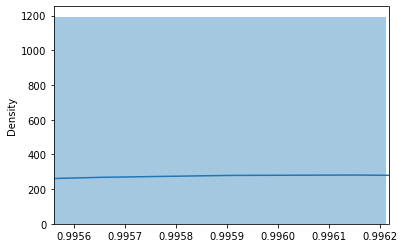

In [51]:
import seaborn as sns

sns.distplot(prob_tp)
plt.xlim([0.9955599, 0.9962175])


In [57]:
prob_tp

[0.9961245656013489,
 0.9961230158805847,
 0.9961265921592712,
 0.9961764812469482,
 0.9961644411087036,
 0.9961687922477722,
 0.9961638450622559,
 0.9961416125297546,
 0.9961251616477966,
 0.9961766004562378,
 0.9961219429969788,
 0.9961282014846802,
 0.9961704611778259,
 0.996163010597229,
 0.9961189031600952,
 0.9961689114570618,
 0.99610435962677,
 0.9962047934532166,
 0.9961407780647278,
 0.996204674243927,
 0.9961159229278564,
 0.9961208701133728,
 0.9962009787559509,
 0.9960739612579346,
 0.9960899353027344,
 0.9961472749710083,
 0.9961703419685364,
 0.996146559715271,
 0.9961801767349243,
 0.996126115322113,
 0.9961650371551514,
 0.996137797832489,
 0.9962095022201538,
 0.9961007833480835,
 0.9962131977081299,
 0.9961481094360352,
 0.9961416125297546,
 0.996155321598053,
 0.9961358904838562,
 0.9961186647415161,
 0.9961981177330017,
 0.9960430860519409,
 0.9961714148521423,
 0.9956908822059631,
 0.9961446523666382,
 0.9961621761322021,
 0.9961292743682861,
 0.996029257774353,
 

/home/sidhant/anaconda3/envs/sid/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.9955599, 0.9962175)

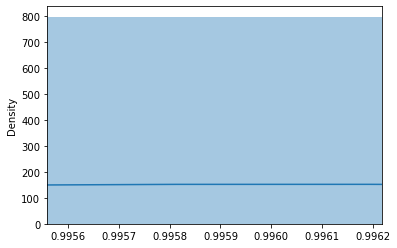

In [52]:
sns.distplot(prob_fp)
plt.xlim([0.9955599, 0.9962175])

In [67]:
prob_fp

[0.9961422085762024,
 0.9961743354797363,
 0.9960947632789612,
 0.9961426854133606,
 0.9961559176445007,
 0.9961352348327637,
 0.9961426854133606,
 0.9959348440170288,
 0.9961155652999878,
 0.9961119294166565,
 0.9961297512054443,
 0.9961354732513428,
 0.9961649179458618,
 0.9960930943489075,
 0.9961040019989014,
 0.9961744546890259,
 0.9960312247276306,
 0.9960792660713196,
 0.9957410097122192,
 0.9961077570915222,
 0.9962174296379089,
 0.9958977103233337,
 0.9960916638374329,
 0.9960500597953796,
 0.9961090683937073,
 0.9961122870445251,
 0.9961113333702087,
 0.996134877204895,
 0.9961192607879639,
 0.9960605502128601,
 0.9958386421203613,
 0.9958581328392029,
 0.9955679774284363,
 0.9960039258003235,
 0.9909679293632507,
 0.9961066842079163,
 0.9957489967346191,
 0.9957013726234436,
 0.9959437251091003,
 0.9959115982055664,
 0.9961048364639282,
 0.9959555864334106,
 0.995999813079834,
 0.9961135387420654,
 0.985625684261322,
 0.9961137771606445,
 0.995790421962738,
 0.99600934982299

In [56]:
print(len(prob_tp))
print(len(prob_fp))
tp=len(prob_tp)
fp=len(prob_fp)
precision=tp/(tp+fp)
recall=tp/143
f1=2*precision*recall/(precision+recall)
print(precision)
print(recall)
print(f1)

126
95
0.5701357466063348
0.8811188811188811
0.6923076923076924


In [30]:
tp=0
fp=0

for i in range(len(prob_tp)):
    if prob_tp[i]>0.99616:
        tp+=1
for i in range(len(prob_fp)):
    if prob_fp[i]>0.99616:
        fp+=1
print(tp)
print(fp)
precision=tp/(tp+fp)
recall=tp/143
f1=2*precision*recall/(precision+recall)
print(precision)
print(recall)
print(f1)

19
5
0.7916666666666666
0.13286713286713286
0.22754491017964074


In [36]:
print(len(prob_tp)+len(prob_fp))
print(len(prob))


221
286


Unlabelled

In [66]:
prob_tp_ser=pd.Series(prob_tp)
prob_tp_ser.describe()

count    15278.000000
mean         0.995911
std          0.004171
min          0.578289
25%          0.996057
50%          0.996115
75%          0.996146
max          0.996217
dtype: float64

/home/sidhant/anaconda3/envs/sid/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.996057, 0.996217)

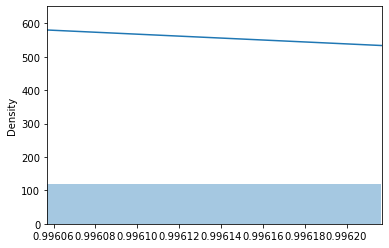

In [68]:
import seaborn as sns

sns.distplot(prob_tp)
plt.xlim([0.996057, 0.996217])

In [69]:
len(max_result_noisy_train[-1])

18475

In [35]:
len(prob)

2000

In [59]:
import pickle
with open("test_labels/sentiment_25_cot1.txt", "wb") as f:   #Pickling
    sentiment_labels=max_result_noisy_train[-1]
    pickle.dump(sentiment_labels, f)
f.close()

In [28]:
len(max_result_test[-1])

286

In [30]:
import pickle
with open("val_labels/sentiment_25_labels.txt", "wb") as f:   #Pickling
    sentiment_labels=max_result_test[-1]
    pickle.dump(sentiment_labels, f)
f.close()

# 2000eval

In [32]:
test_dataloader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size=12,
                )

In [34]:
torch.cuda.empty_cache() 
model = BertForSequenceClassification.from_pretrained("../../sentiment/sentiment/model/f1/sentiment_25/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, test_dataloader)
print(f"batch_size: {12} epoch: {4} result_test: {max_result_test}")

 check_val_accuracy: 0.6695
batch_size: 12 epoch: 4 result_test: [1.775649806762025, 66.99101796407186, 0.6330390920554855, 0.9270544783010157, 0.7523417010116148, 0.40331003454647707, 0.8091787439613527, 0.3653217011995638, 0.5033809166040571, 0.39430320150659137, 0.3988066180265342, [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,

In [32]:
import pickle
with open("2000/test_labels/sentiment_25_labels.txt", "wb") as f:   #Pickling
    sentiment_labels=max_result_test[-1]
    pickle.dump(sentiment_labels, f)
f.close()

In [36]:
import pickle
with open("2000/test_labels/sentiment_25_prob.txt", "wb") as f:   #Pickling
#     sentiment_labels=max_result_test[-1]
    pickle.dump(prob, f)
f.close()

In [38]:
torch.cuda.empty_cache() 
model = BertForSequenceClassification.from_pretrained("../../sentiment/sentiment/model/f1/sentiment_25/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, val_dataloader)
print(f"batch_size: {12} epoch: {4} result_test: {max_result_test}")

 check_val_accuracy: 0.6083916083916084
batch_size: 12 epoch: 4 result_test: [2.094836361706257, 60.625, 0.5701357466063348, 0.8811188811188811, 0.6923076923076924, 0.38020519010259507, 0.7384615384615385, 0.3356643356643357, 0.4615384615384616, 0.37325038880248834, 0.3767277894525417, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0

In [40]:
import pickle
with open("2000/val_labels/sentiment_25_labels.txt", "wb") as f:   #Pickling
    sentiment_labels=max_result_test[-1]
    pickle.dump(sentiment_labels, f)
f.close()

In [41]:
import pickle
with open("2000/val_labels/sentiment_25_prob.txt", "wb") as f:   #Pickling
#     sentiment_labels=max_result_test[-1]
    pickle.dump(prob, f)
f.close()

Connor

In [33]:
torch.cuda.empty_cache() 
model = BertForSequenceClassification.from_pretrained("../../sentiment/sentiment/model/f1/sentiment_25/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, test_dataloader)
print(f"batch_size: {12} epoch: {4} result_test: {max_result_test}")

 check_val_accuracy: 0.57
batch_size: 12 epoch: 4 result_test: [2.5114069514804416, 54.62962962962963, 0.44155844155844154, 1.0, 0.6126126126126126, 0.33203125, 1.0, 0.3484848484848485, 0.5168539325842696, 0.42124542124542125, 0.37663833562271065, [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]]
